In [1]:
!pip install sktime -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 13.5 MB/s eta 0:00:00


In [2]:
import pymc as pm
import numpy as np
import pandas as pd
import pytensor.tensor as pt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az
from prophet import Prophet
import scipy
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error
import pytensor
import math
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
import seaborn as sns
from scipy.stats.mstats import mquantiles
from scipy import optimize
from prophet import Prophet
from plotnine import *

az.style.use('arviz-white')

In [3]:
# Load data
train_df = pd.read_csv('/content/drive/MyDrive/mmm_data/train_data.csv')
train_df.drop(columns=["category"], inplace=True)

test_df = pd.read_csv('/content/drive/MyDrive/mmm_data/test_data.csv')
test_df.drop(columns=["category"], inplace=True)

seasonal_df = pd.read_csv('/content/drive/MyDrive/mmm_data/seasonal_components.csv')
seasonal_df.drop(columns="revenue", inplace=True)

In [4]:
train_df = train_df.merge(seasonal_df, on='date', how='left')
test_df = test_df.merge(seasonal_df, on='date', how='left')

In [5]:
transform_variables = ["ad_expense_sms", "ad_expense_newspaper", "ad_expense_radio", "ad_expense_tv", "ad_expense_internet",
                       "demand", "consumer_price_index", "consumer_confidence_index", "producer_price_index", "unit_price",
                       "gross_rating_point_newspaper", "gross_rating_point_sms", "gross_rating_point_radio", "gross_rating_point_internet",
                       "gross_rating_point_tv", "trend", "weekly", "yearly"]

delay_channels = ["ad_expense_sms", "ad_expense_newspaper", "ad_expense_radio", "ad_expense_tv", "ad_expense_internet"]

media_channels = ["ad_expense_sms", "ad_expense_newspaper", "ad_expense_radio", "ad_expense_tv", "ad_expense_internet"]

control_variables = ["demand", "consumer_price_index", "consumer_confidence_index", "producer_price_index", "unit_price", "gross_rating_point_newspaper", "gross_rating_point_sms",
                     "gross_rating_point_radio", "gross_rating_point_internet", "gross_rating_point_tv"]

fourier_seasonal_features = ["fourier_sin_order_1", "fourier_cos_order_1", "fourier_sin_order_2", "fourier_cos_order_2", "fourier_sin_order_3", "fourier_cos_order_3"]

prophet_seasonal_features = ["trend", "weekly", "yearly"]

target = "revenue"

# Features and Target transformation


In [6]:
# Train data transform
selected_features = delay_channels + control_variables + fourier_seasonal_features + prophet_seasonal_features
train_transformed = train_df.copy()
numerical_encoder_dict = {}

for feature in selected_features:
    scaler = MinMaxScaler()
    original = train_df[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    train_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scalerdependent_transformation = None

original_target = train_df[target].values

# Target: 100k scale
train_transformed[target] = original_target / 100000

In [7]:
# Test data
test_transformed = test_df.copy()
numerical_encoder_dict = {}

for feature in selected_features:
    scaler = MinMaxScaler()
    original = test_df[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    test_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scalerdependent_transformation = None

original_target = test_df[target].values

# Target: 100k scale
test_transformed[target] = original_target / 100000

# Bayesian model fitting

In [8]:
def adstock_geometric(x, theta):
    x = pt.as_tensor_variable(x)

    def adstock_geometric_recurrence(index, input_x, decay_x, theta):
        return pt.set_subtensor(decay_x[index], pt.sum(input_x + theta * decay_x[index - 1]))

    len_observed = x.shape[0]

    x_decayed = pt.zeros_like(x)
    x_decayed = pt.set_subtensor(x_decayed[0], x[0])

    output, _ = pytensor.scan(
        fn = adstock_geometric_recurrence,
        sequences = [pt.arange(1, len_observed), x[1:len_observed]],
        outputs_info = x_decayed,
        non_sequences = theta,
        n_steps = len_observed - 1
    )

    return output[-1]

def saturation_hill(x, alpha, gamma):

    x_s_hill = x ** alpha / (x ** alpha + gamma ** alpha)

    return x_s_hill

# Bayesian Model with Fourier Seasonal Features

In [9]:
fourier_seasonal_features

['fourier_sin_order_1',
 'fourier_cos_order_1',
 'fourier_sin_order_2',
 'fourier_cos_order_2',
 'fourier_sin_order_3',
 'fourier_cos_order_3']

In [10]:
response_mean = []
# coords = {"time": train_transformed.index.tolist()} #coords=coords

with pm.Model() as model_fourier:
  model_fourier.add_coord("time", train_transformed.index.tolist(), mutable = True)
  #  ad_expense_sms
  adstock_param = pm.Beta(f"ad_expense_sms_adstock", 3, 3)
  saturation_gamma = pm.Beta(f"ad_expense_sms_gamma", 2, 2)
  saturation_alpha = pm.Gamma(f"ad_expense_sms_alpha", 3, 1)
  x_ad_expense_sms = pm.MutableData("ad_expense_sms",train_transformed["ad_expense_sms"].values)
  x_new_ad_expense_sms = adstock_geometric(x_ad_expense_sms, adstock_param)
  saturation_tensor = saturation_hill(x_new_ad_expense_sms, saturation_alpha, saturation_gamma)
  channel_beta = pm.HalfNormal(f"ad_expense_sms_media_coef", sigma = 3, dims="time")
  response_mean.append(saturation_tensor * channel_beta)

  #  ad_expense_newspaper
  adstock_param = pm.Beta(f"ad_expense_newspaper_adstock", 3, 3)
  saturation_gamma = pm.Beta(f"ad_expense_newspaper_gamma", 2, 2)
  saturation_alpha = pm.Gamma(f"ad_expense_newspaper_alpha", 3, 1)
  x_ad_expense_newspaper = pm.MutableData("ad_expense_newspaper",train_transformed["ad_expense_newspaper"].values)
  x_new_ad_expense_newspaper = adstock_geometric(x_ad_expense_newspaper, adstock_param)
  saturation_tensor = saturation_hill(x_new_ad_expense_newspaper, saturation_alpha, saturation_gamma)
  channel_beta = pm.HalfNormal(f"ad_expense_newspaper_media_coef", sigma = 3, dims="time")
  response_mean.append(saturation_tensor * channel_beta)

  #  ad_expense_radio
  adstock_param = pm.Beta(f"ad_expense_radio_adstock", 3, 3)
  saturation_gamma = pm.Beta(f"ad_expense_radio_gamma", 2, 2)
  saturation_alpha = pm.Gamma(f"ad_expense_radio_alpha", 3, 1)
  x_ad_expense_radio = pm.MutableData("ad_expense_radio",train_transformed["ad_expense_radio"].values)
  x_new_ad_expense_radio = adstock_geometric(x_ad_expense_radio, adstock_param)
  saturation_tensor = saturation_hill(x_new_ad_expense_radio, saturation_alpha, saturation_gamma)
  channel_beta = pm.HalfNormal(f"ad_expense_radio_media_coef", sigma = 3, dims="time")
  response_mean.append(saturation_tensor * channel_beta)

  #  ad_expense_tv
  adstock_param = pm.Beta(f"ad_expense_tv_adstock", 3, 3)
  saturation_gamma = pm.Beta(f"ad_expense_tv_gamma", 2, 2)
  saturation_alpha = pm.Gamma(f"ad_expense_tv_alpha", 3, 1)
  x_ad_expense_tv = pm.MutableData("ad_expense_tv",train_transformed["ad_expense_tv"].values)
  x_new_ad_expense_tv = adstock_geometric(x_ad_expense_tv, adstock_param)
  saturation_tensor = saturation_hill(x_new_ad_expense_tv, saturation_alpha, saturation_gamma)
  channel_beta = pm.HalfNormal(f"ad_expense_tv_media_coef", sigma = 3, dims="time")
  response_mean.append(saturation_tensor * channel_beta)

  #  ad_expense_internet
  adstock_param = pm.Beta(f"ad_expense_internet_adstock", 3, 3)
  saturation_gamma = pm.Beta(f"ad_expense_internet_gamma", 2, 2)
  saturation_alpha = pm.Gamma(f"ad_expense_internet_alpha", 3, 1)
  x_ad_expense_internet = pm.MutableData("ad_expense_internet",train_transformed["ad_expense_internet"].values)
  x_new_ad_expense_internet = adstock_geometric(x_ad_expense_internet, adstock_param)
  saturation_tensor = saturation_hill(x_new_ad_expense_internet, saturation_alpha, saturation_gamma)
  channel_beta = pm.HalfNormal(f"ad_expense_internet_media_coef", sigma = 3, dims="time")
  response_mean.append(saturation_tensor * channel_beta)

  # Add control variables
  # demand
  x_demand = pm.MutableData("demand",train_transformed["demand"].values)
  control_beta = pm.Normal(f"demand_control_coef", sigma = 3)
  control_demand = control_beta * x_demand
  response_mean.append(control_demand)

  # consumer_price_index
  x_consumer_price_index = pm.MutableData("consumer_price_index",train_transformed["consumer_price_index"].values)
  control_beta = pm.Normal(f"consumer_price_index_control_coef", sigma = 3)
  control_consumer_price_index = control_beta * x_consumer_price_index
  response_mean.append(control_consumer_price_index)

  # consumer_confidence_index
  x_consumer_confidence_index = pm.MutableData("consumer_confidence_index",train_transformed["consumer_confidence_index"].values)
  control_beta = pm.Normal(f"consumer_confidence_index_coef", sigma = 3)
  control_consumer_confidence_index = control_beta * x_consumer_confidence_index
  response_mean.append(control_consumer_confidence_index)

  # producer_price_index
  x_producer_price_index = pm.MutableData("producer_price_index",train_transformed["producer_price_index"].values)
  control_beta = pm.Normal(f"producer_price_index_control_coef", sigma = 3)
  control_producer_price_index = control_beta * x_producer_price_index
  response_mean.append(control_producer_price_index)

  # unit_price
  x_unit_price = pm.MutableData("unit_price",train_transformed["unit_price"].values)
  control_beta = pm.Normal(f"unit_price_control_coef", sigma = 3)
  control_unit_price = control_beta * x_unit_price
  response_mean.append(control_unit_price)

  # Add Fourier seasonal features
  # fourier_sin_order_1
  x_fourier_sin_order_1 = pm.MutableData("fourier_sin_order_1",train_transformed["fourier_sin_order_1"].values)
  control_beta = pm.Normal(f"fourier_sin_order_1_control_coef", sigma = 3)
  control_fourier_sin_order_1= control_beta * x_fourier_sin_order_1
  response_mean.append(control_fourier_sin_order_1)

  # fourier_sin_order_2
  x_fourier_sin_order_2 = pm.MutableData("fourier_sin_order_2",train_transformed["fourier_sin_order_2"].values)
  control_beta = pm.Normal(f"fourier_sin_order_2_control_coef", sigma = 3)
  control_fourier_sin_order_2= control_beta * x_fourier_sin_order_2
  response_mean.append(control_fourier_sin_order_2)

  # fourier_sin_order_3
  x_fourier_sin_order_3 = pm.MutableData("fourier_sin_order_3",train_transformed["fourier_sin_order_3"].values)
  control_beta = pm.Normal(f"fourier_sin_order_3_control_coef", sigma = 3)
  control_fourier_sin_order_3= control_beta * x_fourier_sin_order_3
  response_mean.append(control_fourier_sin_order_3)

  # fourier_cos_order_1
  x_fourier_cos_order_1 = pm.MutableData("fourier_cos_order_1",train_transformed["fourier_cos_order_1"].values)
  control_beta = pm.Normal(f"fourier_cos_order_1_control_coef", sigma = 3)
  control_fourier_cos_order_1= control_beta * x_fourier_cos_order_1
  response_mean.append(control_fourier_cos_order_1)

  # fourier_cos_order_2
  x_fourier_cos_order_2 = pm.MutableData("fourier_cos_order_2",train_transformed["fourier_cos_order_2"].values)
  control_beta = pm.Normal(f"fourier_cos_order_2_control_coef", sigma = 3)
  control_fourier_cos_order_2= control_beta * x_fourier_cos_order_2
  response_mean.append(control_fourier_cos_order_2)

  # fourier_cos_order_3
  x_fourier_cos_order_3 = pm.MutableData("fourier_cos_order_3",train_transformed["fourier_cos_order_3"].values)
  control_beta = pm.Normal(f"fourier_cos_order_3_control_coef", sigma = 3)
  control_fourier_cos_order_3= control_beta * x_fourier_cos_order_3
  response_mean.append(control_fourier_cos_order_3)


  # Intercept term
  intercept = pm.Normal("intercept", np.mean(train_transformed[target].values), sigma = 3)

  # Adding noise term"
  sigma = pm.Normal("sigma", 4)

  revenue = pm.MutableData('revenue', train_transformed[target].values, dims="time")

  # Bayesian linear model
  likelihood = pm.Normal(
      "outcome",
      mu = intercept + sum(response_mean),
      sigma = sigma,
      observed = revenue, #train_transformed[target].values,
      dims="time"
  )

  prior_pred = pm.sample_prior_predictive()
  trace = pm.sample(4, tune=4, random_seed=42, return_inferencedata=False)

In [11]:
# pm.model_to_graphviz(model_basic)

In [12]:
# pm.plot_trace(trace)

In [13]:
# pm.plot_posterior(trace)

# Update dimensions in order to get posterior samples on test set

In [14]:
delay_channels

['ad_expense_sms',
 'ad_expense_newspaper',
 'ad_expense_radio',
 'ad_expense_tv',
 'ad_expense_internet']

In [15]:
test_data = {
  "ad_expense_sms":test_transformed["ad_expense_sms"].values,
  "ad_expense_newspaper":test_transformed["ad_expense_newspaper"].values,
  "ad_expense_radio":test_transformed["ad_expense_radio"].values,
  "ad_expense_tv":test_transformed["ad_expense_tv"].values,
  "ad_expense_internet":test_transformed["ad_expense_internet"].values,
  "demand":test_transformed["demand"].values,
  "consumer_price_index":test_transformed["consumer_price_index"].values,
  "consumer_confidence_index":test_transformed["consumer_confidence_index"].values,
  "producer_price_index":test_transformed["producer_price_index"].values,
  "unit_price":test_transformed["unit_price"].values,
  "fourier_sin_order_1":test_transformed["fourier_sin_order_1"].values,
  "fourier_sin_order_2":test_transformed["fourier_sin_order_2"].values,
  "fourier_sin_order_3":test_transformed["fourier_sin_order_3"].values,
  "fourier_cos_order_1":test_transformed["fourier_cos_order_1"].values,
  "fourier_cos_order_2":test_transformed["fourier_cos_order_2"].values,
  "fourier_cos_order_3":test_transformed["fourier_cos_order_3"].values,
  "revenue":test_transformed["revenue"].values
}

test_coords = {"time":test_transformed.index.tolist()}

with model_fourier:
  pm.set_data(test_data, coords=test_coords)
  posterior_pred  = pm.sample_posterior_predictive(
      trace,
      var_names=['revenue'],
      return_inferencedata=True,
      extend_inferencedata=True)

# Get posterior samples for test set

In [16]:
with model_fourier:
  ppc_test = pm.sample_posterior_predictive(trace)

In [17]:
ppc_test

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

# Get mean posterior distribution

In [18]:
post_nested_list = ppc_test.posterior_predictive["outcome"][0]
post_array = np.array(post_nested_list)
y_pred_mean = np.mean(post_array, axis=0)

y_true = test_transformed[target].values.tolist()

Text(0, 0.5, 'Revenue 100K')

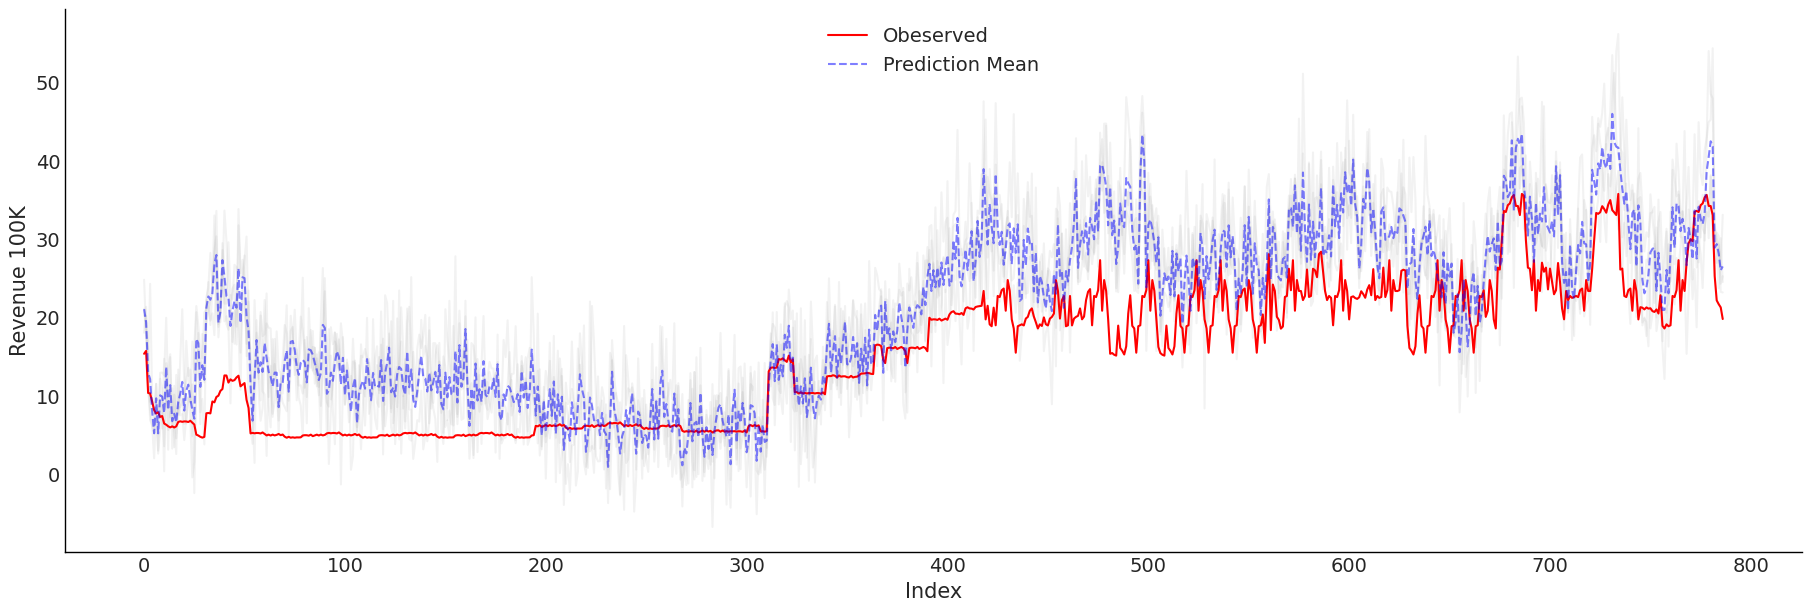

In [19]:
fig, ax = plt.subplots(figsize = (18, 6))

for sublist in ppc_test.posterior_predictive["outcome"][0]:
  _ = ax.plot(sublist.T, color = "0.5", alpha = 0.1)

ax.plot(y_true, color = "red", label="Obeserved")
ax.plot(y_pred_mean, color = "blue", linestyle='dashed', alpha = 0.5, label="Prediction Mean")
plt.legend(loc='upper center')
plt.xlabel("Index")
plt.ylabel("Revenue 100K")

# Model performance evaluation

Residuals vs Predictions: Use this plot to assess whether the model's predictions are consistent across the range of observed values.

Residuals vs Actuals: Use this plot to understand the distribution of errors in relation to the actual data points. Look for any systematic patterns or outliers.

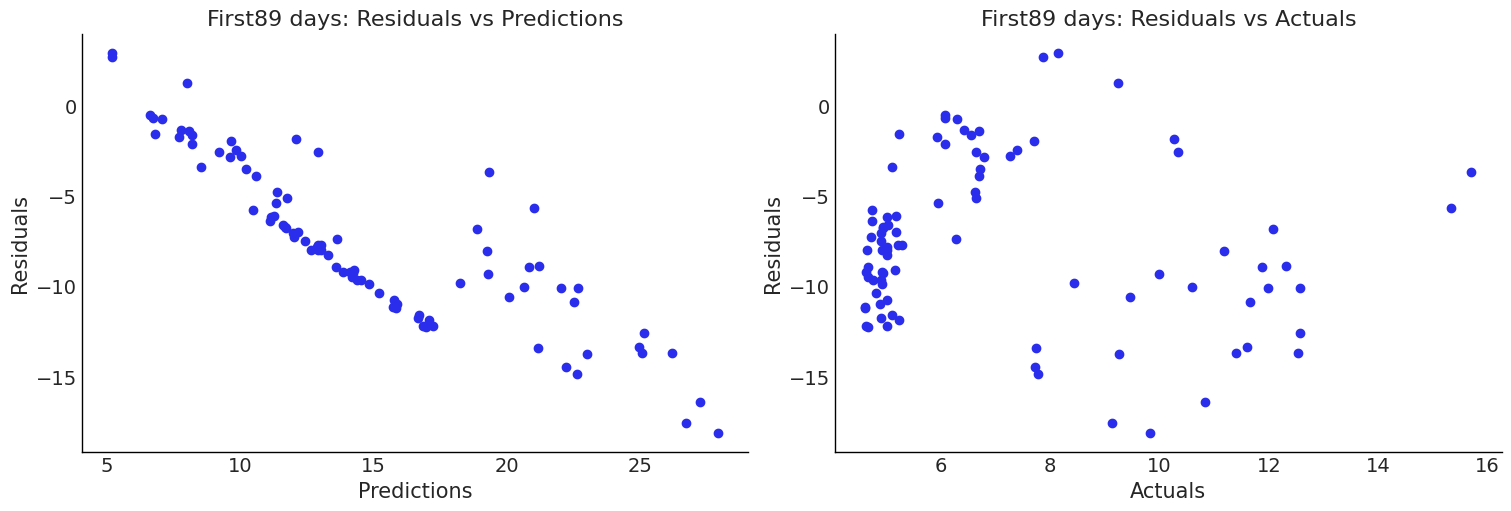

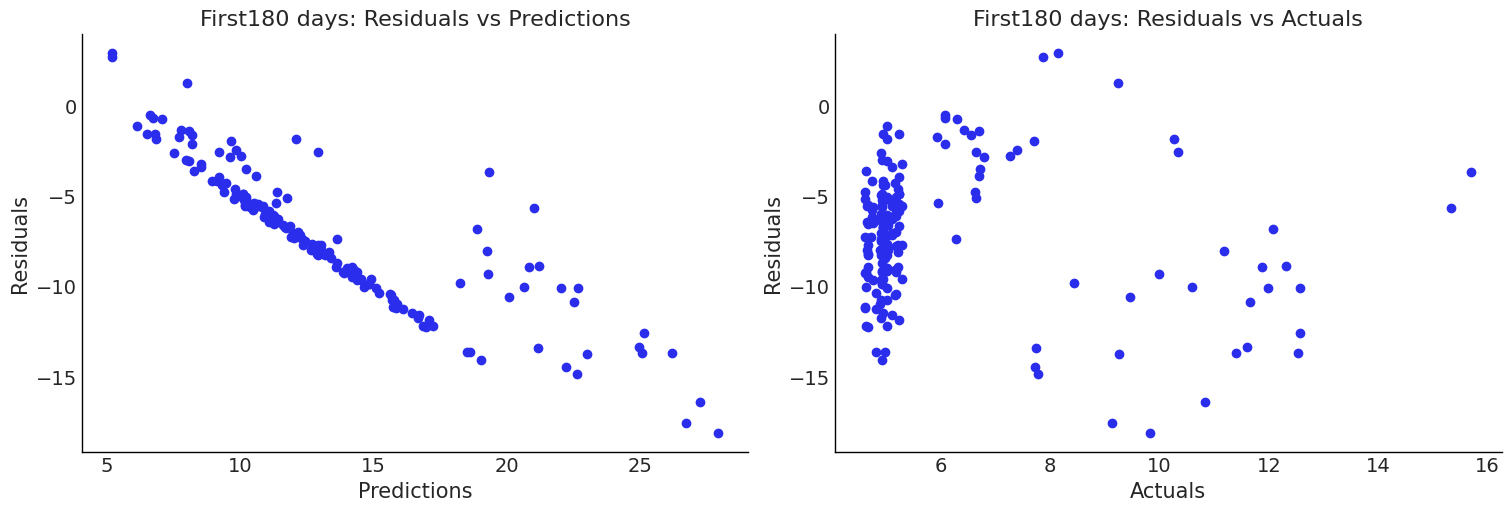

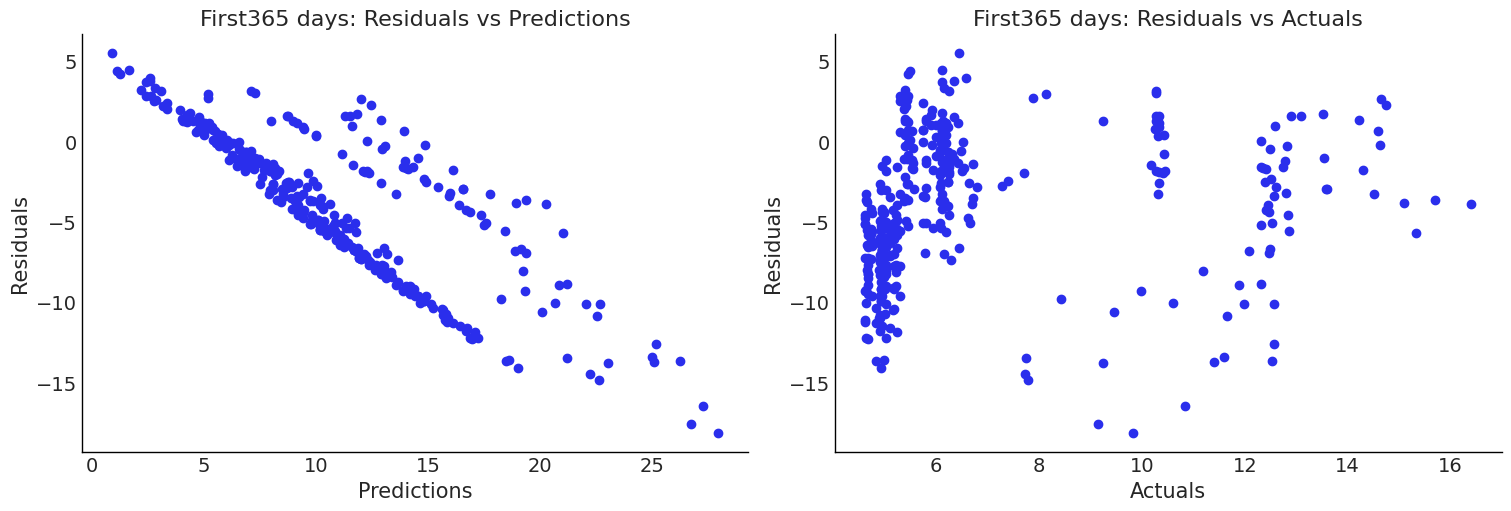

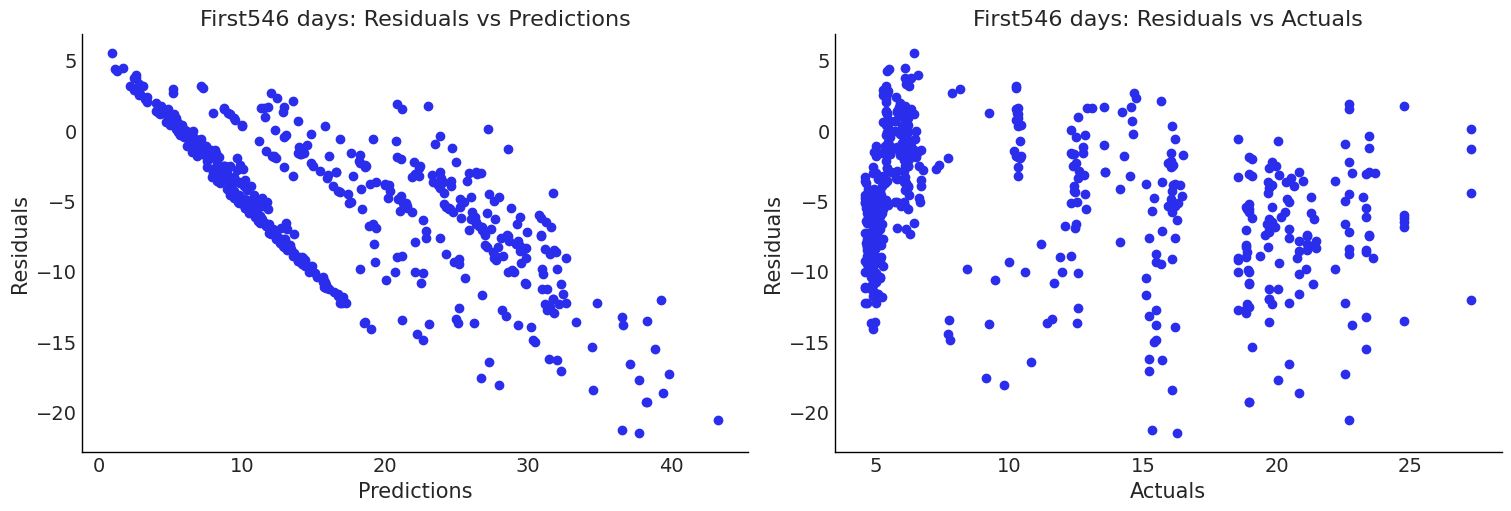

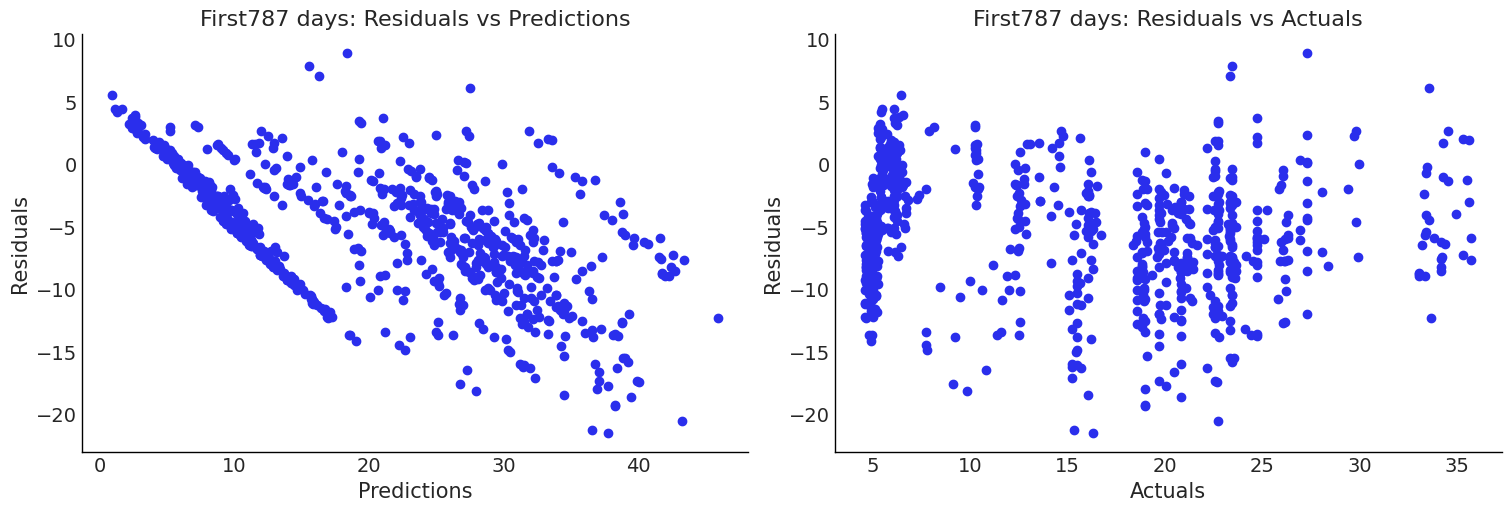

In [20]:
results_list = []
for inf_days in [89,180,365,546,787]:

  linear_rmse = np.sqrt(mean_squared_error(y_true[:inf_days], y_pred_mean[:inf_days]))
  linear_r2 = r2_score(y_true[:inf_days], y_pred_mean[:inf_days])
  linear_smape = mean_absolute_percentage_error(y_true[:inf_days], y_pred_mean[:inf_days], symmetric=True)
  linear_mae = mean_absolute_error(y_true[:inf_days], y_pred_mean[:inf_days], symmetric=True)

  results_list.append({
      'inference_days': inf_days,
      'rmse': linear_rmse,
      'r2': linear_r2,
      'smape': linear_smape,
      'mae': linear_mae
  })

  residuals = y_true[:inf_days]- y_pred_mean[:inf_days]

  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
  ax[0].scatter(y_pred_mean[:inf_days], residuals)
  ax[1].scatter(y_true[:inf_days],residuals)

  ax[0].set_xlabel('Predictions')
  ax[0].set_ylabel('Residuals')
  ax[1].set_xlabel('Actuals')
  ax[1].set_ylabel('Residuals')

  ax[0].set_title(f'First{inf_days} days: Residuals vs Predictions')
  ax[1].set_title(f'First{inf_days} days: Residuals vs Actuals')

  plt.legend()
  plt.show()


In [21]:
results_df = pd.DataFrame(results_list)
results_df

,inference_days,rmse,r2,smape,mae
0,89,8.837951,-8.987146,0.691570,7.771717
1,180,8.066154,-11.822024,0.737858,7.264871
2,365,6.102955,-3.565361,0.534382,4.869494
3,546,7.188790,-0.163651,0.462008,5.791359
4,787,7.364094,0.272923,0.396010,6.064498
